In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

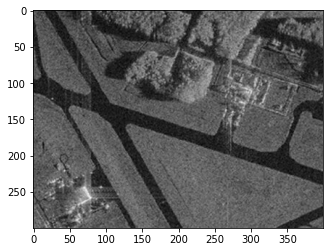

In [4]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

In [52]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False
    

In [53]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255
    

In [67]:
seed_point = (250,250)
mask = region_growing(image_gray,seed_point,homo_average,1, 10)

3
,4
,4
,5
,7
,6
,6
,9
,7
,6
,6
,9
,13
,12
,15
,17
,13
,13
,16
,16
,14
,16
,15
,16
,10
,11
,14
,13
,14
,10
,10
,14
,17
,15
,36
,22
,21
,18
,21
,21
,25
,23
,43
,31
,34
,23
,20
,27
,29
,35
,40
,32
,35
,42
,48
,52
,30
,23
,20
,19
,19
,20
,18
,22
,74
,24
,26
,29
,30
,27
,29
,29
,28
,29
,20
,17
,17
,21
,20
,25
,23
,24
,20
,18
,19
,15
,18
,18
,15
,18
,13
,10
,9
,7
,9
,9
,10
,11
,12
,10
,12
,11
,8
,9
,7
,4
,3
,6
,6
,6
,5
,5
,5
,3
,2
,2
,2
,1
,0


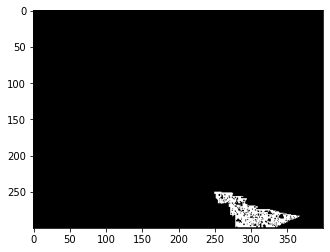

In [68]:
plt.imshow(mask, cmap="gray")

# K-means

In [7]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [8]:
flags = cv2.KMEANS_RANDOM_CENTERS

In [10]:
z = image_gray.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

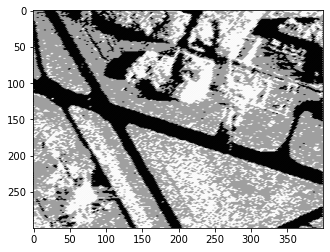

In [11]:
plt.imshow(res2, cmap="gray")

# Watershed+Distance transform

In [5]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

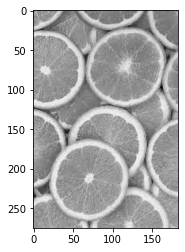

In [6]:
plt.imshow(image_gray, cmap="gray")

In [7]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

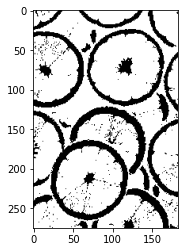

In [8]:
plt.imshow(thresh, cmap="gray")

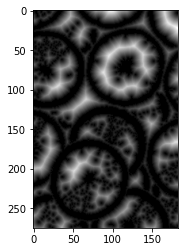

In [9]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

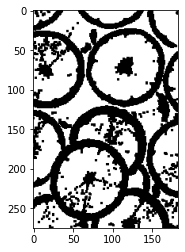

In [11]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

In [20]:
sure_fg = sure_fg.astype(np.uint8)

In [21]:
ret, markers = cv2.connectedComponents(sure_fg) 

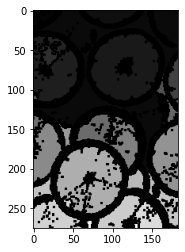

In [22]:
plt.imshow(markers, cmap="gray")

In [30]:
markers = cv2.watershed(image, markers)

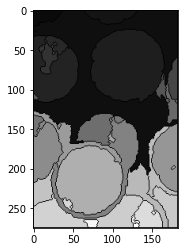

In [34]:
plt.imshow(markers, cmap="gray")

In [35]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import segmentation, feature

Matplotlib is building the font cache; this may take a moment.


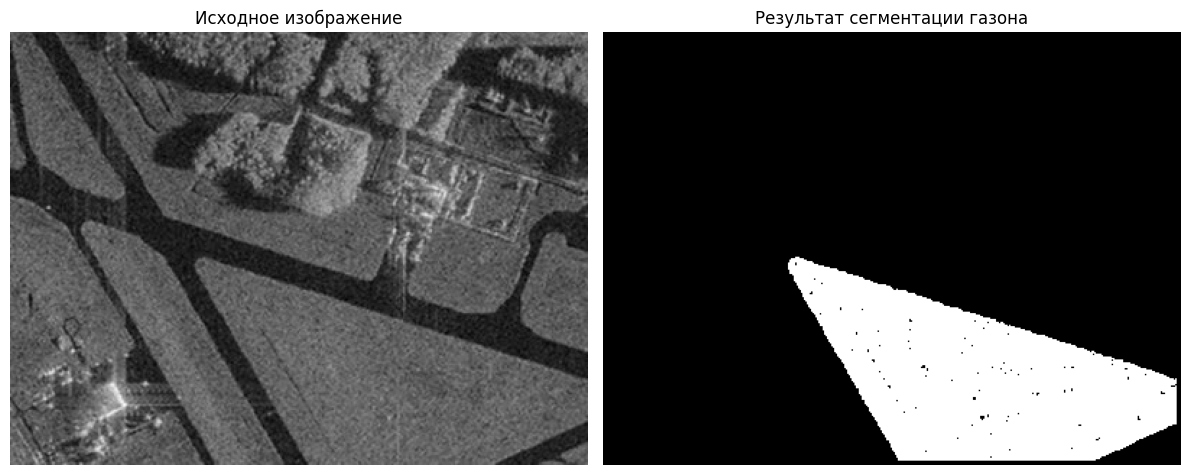

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis('off')

def homo_average(img, mask, point, T):
    if np.count_nonzero(mask) == 0:
        return False
    
    region_pixels = img[mask > 0]
    if len(region_pixels) == 0:
        return True
        
    mean_val = np.mean(region_pixels)
    std_val = np.std(region_pixels)
    
    point_val = img[point]
    
    if abs(point_val - mean_val) <= T:
        return True
    
    return False

def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape[:2], np.uint8)
    mask[seed_point] = 1
    
    height, width = image.shape[:2]
    
    changed = True
    while changed:
        changed = False
        for i in range(r, height - r):
            for j in range(r, width - r):
                if mask[i, j] == 0:
                    region_around = mask[i-r:i+r+1, j-r:j+r+1]
                    if np.any(region_around > 0):
                        if homo_fun(image, mask, (i, j), T):
                            mask[i, j] = 1
                            changed = True
    
    return mask * 255

seed_point = (250, 250)
mask = region_growing(image_gray, seed_point, homo_average, 3, 25)

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Результат сегментации газона")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def homo_gradient(img, mask, point, T):
    if np.count_nonzero(mask) == 0:
        return False
    
    y, x = point
    current_val = img[y, x]
    
    if mask[y, x] == 1:
        return False
    
    neighbors = []
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            ny, nx = y + dy, x + dx
            if 0 <= ny < img.shape[0] and 0 <= nx < img.shape[1]:
                if mask[ny, nx] > 0:
                    neighbors.append(img[ny, nx])
    
    if not neighbors:
        return False
    
    avg_neighbor = np.mean(neighbors)
    
    gradient = abs(current_val - avg_neighbor)
    
    if gradient <= T:
        return True
    
    return False

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis('off')

mask_average = region_growing(image_gray, seed_point, homo_average, 3, 25)
plt.subplot(1, 3, 2)
plt.imshow(mask_average, cmap="gray")
plt.title("Критерий по среднему")
plt.axis('off')

mask_gradient = region_growing(image_gray, seed_point, homo_gradient, 3, 20)
plt.subplot(1, 3, 3)
plt.imshow(mask_gradient, cmap="gray")
plt.title("Критерий по градиенту")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Площадь сегмента (среднее): {np.count_nonzero(mask_average)} пикселей")
print(f"Площадь сегмента (градиент): {np.count_nonzero(mask_gradient)} пикселей")

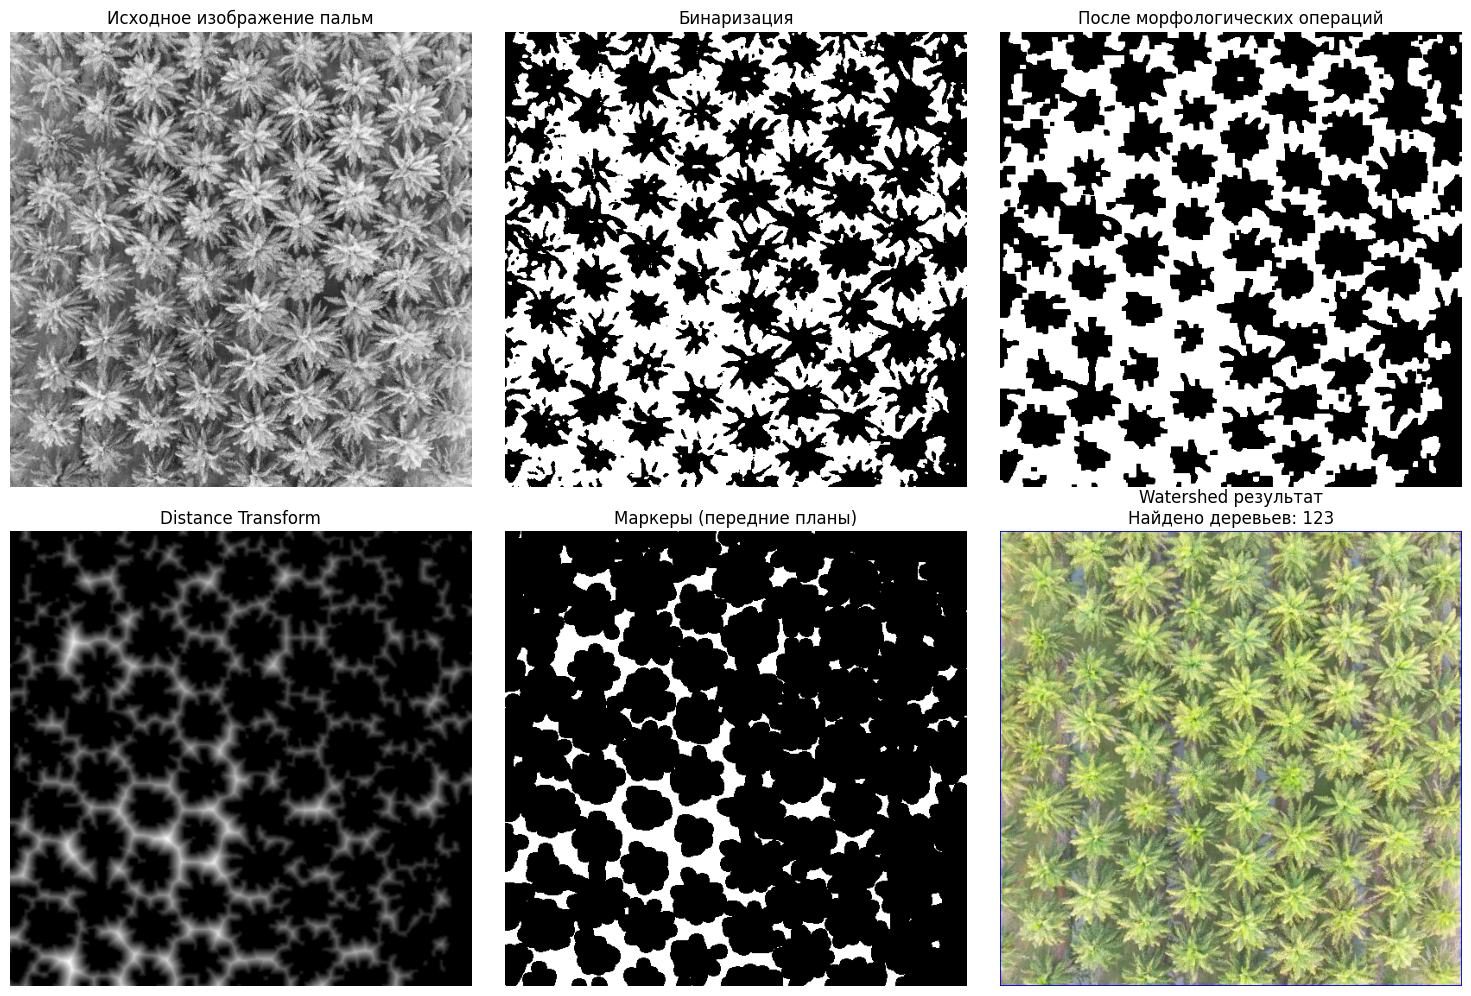

Количество обнаруженных пальмовых деревьев: 123


In [4]:
palm_image = cv2.imread('palm_1.JPG')
palm_gray = cv2.cvtColor(palm_image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(palm_gray, cmap="gray")
plt.title("Исходное изображение пальм")
plt.axis('off')

palm_filtered = cv2.medianBlur(palm_gray, 5)

ret, thresh = cv2.threshold(palm_filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.subplot(2, 3, 2)
plt.imshow(thresh, cmap="gray")
plt.title("Бинаризация")
plt.axis('off')

kernel = np.ones((3,3), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.subplot(2, 3, 3)
plt.imshow(thresh, cmap="gray")
plt.title("После морфологических операций")
plt.axis('off')

dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

plt.subplot(2, 3, 4)
plt.imshow(dist_transform, cmap="gray")
plt.title("Distance Transform")
plt.axis('off')

ret, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, cv2.THRESH_BINARY)

plt.subplot(2, 3, 5)
plt.imshow(sure_fg, cmap="gray")
plt.title("Маркеры (передние планы)")
plt.axis('off')

sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers = cv2.watershed(palm_image, markers)

plt.subplot(2, 3, 6)
result_image = palm_image.copy()
result_image[markers == -1] = [255, 0, 0]

result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
plt.imshow(result_image_rgb)
plt.title(f"Watershed результат\nНайдено деревьев: {ret-1}")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Количество обнаруженных пальмовых деревьев: {ret-1}")